In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

### Data Transform, dataset, dataloader

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((128,128)),

])

dataset_train = ImageFolder(
    "clouds/clouds_train",
    transform=train_transform
)
dataloader_train = DataLoader(
    dataset=dataset_train,
    shuffle=True,
    batch_size=1
)


In [3]:
len(dataset_train)

474

### Display images

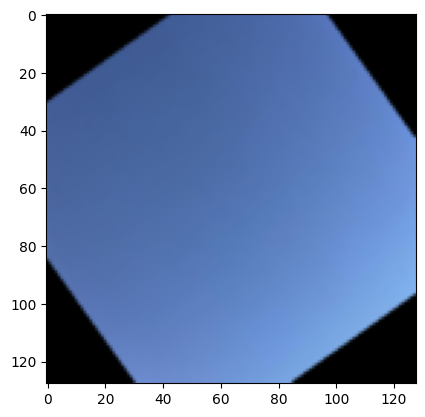

In [4]:
import matplotlib.pyplot as plt
image, label = next(iter(dataloader_train))
image_to_display = image.squeeze().permute(1,2,0)
plt.imshow(image_to_display)

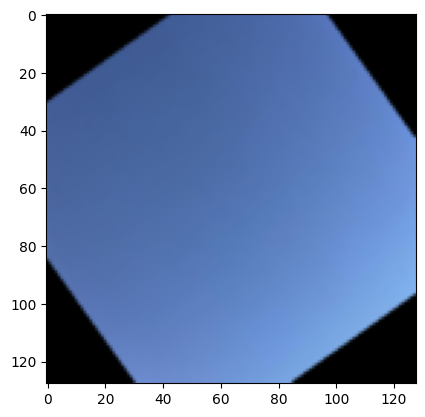

In [5]:
flip = transforms.RandomHorizontalFlip()
image_flip = flip(image_to_display)
plt.imshow(image_flip)

### Model


In [6]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            #input 3x128x128
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), #3 channel to 32 channel
            #(128+2x1-3)/1 + 1 -> 32x128x128
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), # out -> 32x64x64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            #(64+2x1-3)/1 + 1 = 64 -> 64x64x64
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), # out -> 64x32x32
            nn.Flatten()
        )
        self.classifier = nn.Linear(64*32*32, num_classes)

    def forward(self, x):
        x =self.feature_extractor(x)
        x =self.classifier(x)
        return x

### Training loop

In [7]:
from torchinfo import summary
net = Net(7)
summary(net, input_size=(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 7]                    --
├─Sequential: 1-1                        [1, 65536]                --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         896
│    └─ELU: 2-2                          [1, 32, 128, 128]         --
│    └─MaxPool2d: 2-3                    [1, 32, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 64, 64, 64]           18,496
│    └─ELU: 2-5                          [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-6                    [1, 64, 32, 32]           --
│    └─Flatten: 2-7                      [1, 65536]                --
├─Linear: 1-2                            [1, 7]                    458,759
Total params: 478,151
Trainable params: 478,151
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 90.90
Input size (MB): 0.20
Forward/backward pass size (MB): 6.29
Params size (MB): 1.91
Estimated Total Siz

In [8]:
epochs = 100
lr = 0.001

device = torch.device("cuda")
criterion = nn.CrossEntropyLoss()
net = Net(7).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)



for i in range(epochs):
    running_loss = 0.0
    for image, label in dataloader_train:
        optimizer.zero_grad()
        #forward pass
        image = image.to(device)
        label = label.to(device)
        y_pred = net(image)
        loss = criterion(y_pred, label)

        #backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss/len(dataloader_train)
    print(f"Epoch {i+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 2.6721
Epoch 2, Loss: 2.4651
Epoch 3, Loss: 1.9854
Epoch 4, Loss: 1.8433
Epoch 5, Loss: 2.1763
Epoch 6, Loss: 1.8150
Epoch 7, Loss: 1.7020
Epoch 8, Loss: 2.2072
Epoch 9, Loss: 1.8766
Epoch 10, Loss: 3.0454
Epoch 11, Loss: 1.3687
Epoch 12, Loss: 1.4686
Epoch 13, Loss: 1.9169
Epoch 14, Loss: 1.5700
Epoch 15, Loss: 1.8207
Epoch 16, Loss: 1.4860
Epoch 17, Loss: 3.0167
Epoch 18, Loss: 1.3986
Epoch 19, Loss: 1.1357
Epoch 20, Loss: 2.2955
Epoch 21, Loss: 2.0231
Epoch 22, Loss: 1.0145
Epoch 23, Loss: 1.1160
Epoch 24, Loss: 1.6134
Epoch 25, Loss: 1.5844
Epoch 26, Loss: 1.7598
Epoch 27, Loss: 1.4888
Epoch 28, Loss: 1.8701
Epoch 29, Loss: 1.3279
Epoch 30, Loss: 0.9835
Epoch 31, Loss: 2.1628
Epoch 32, Loss: 1.4517
Epoch 33, Loss: 1.4828
Epoch 34, Loss: 1.2125
Epoch 35, Loss: 2.2843
Epoch 36, Loss: 1.5410
Epoch 37, Loss: 1.2577
Epoch 38, Loss: 1.1143
Epoch 39, Loss: 1.1709
Epoch 40, Loss: 1.9849
Epoch 41, Loss: 4.0439
Epoch 42, Loss: 1.1979
Epoch 43, Loss: 0.7121
Epoch 44, Loss: 1.33

In [30]:
from torchmetrics import Precision, Recall

#test dataset and dataloader
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
])
dataset_test = ImageFolder(
    "clouds/clouds_train",
    transform=test_transform
)
dataloader_test = DataLoader(
    dataset=dataset_test,
    shuffle=True,
    batch_size=1
)

metric_precision = Precision(
    task="multiclass", num_classes=7, average="macro" #compute precision per class then taking average
).to(device)
metric_recall = Recall(
    task="multiclass", num_classes=7, average="macro" #compute recall per class then taking average
).to(device)

net.eval()
with torch.no_grad():
    for image, label in dataloader_test:
        image = image.to(device)
        label = label.to(device)
        output = net(image)
        _, preds = torch.max(output,1)
        metric_precision(preds, label)
        metric_recall(preds, label)

precision = metric_precision.compute()
recall = metric_recall.compute()

print(f"the macro average precision is {precision}")
print(f"the macro average recall is {recall}")



the macro average precision is 0.8237719535827637
the macro average recall is 0.777497410774231
the recall per class is tensor([0.6818, 1.0000, 1.0000, 0.5495, 0.9098, 0.4490, 0.8525],
       device='cuda:0')
{'cirriform clouds': 0, 'clear sky': 1, 'cumulonimbus clouds': 2, 'cumulus clouds': 3, 'high cumuliform clouds': 4, 'stratiform clouds': 5, 'stratocumulus clouds': 6}


In [32]:
net.eval()
metric_recall_per = Recall(
    task="multiclass", num_classes=7, average="none" #compute recall per class then taking average
).to(device)

with torch.no_grad():
    for image, label in dataloader_test:
        image = image.to(device)
        label = label.to(device)
        output = net(image)
        _, preds = torch.max(output,1)

        metric_recall_per(preds,label)
recall_per = metric_recall_per.compute()

for k, v in dataset_test.class_to_idx.items():
    print(k,recall_per[v].item())


cirriform clouds 0.6818181872367859
clear sky 1.0
cumulonimbus clouds 1.0
cumulus clouds 0.5494505763053894
high cumuliform clouds 0.9097744226455688
stratiform clouds 0.44897958636283875
stratocumulus clouds 0.8524590134620667
